# Использование машинного обучения для классификации поступающих сообщений

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Описание задачи

В связи со сложной структурой и нелинейными зонами ответственности в органах исполнительной и государственной власти, а также из-за большого потока входящих сообщений разной направленности возникают сложности с оперативной маршрутизацией сообщений непосредственным исполнителям. Сообщение гражданина проходит длинную цепочку передачи «из рук в руки», что существенно уменьшает время, отведенное на непосредственное устранение причин возникновения проблемы. А также растущая популярность платформ обратной связи увеличивает нагрузку на модераторов и приводит к росту штата персонала, обслуживающего работу порталов.


## Цель задачи

Необходимо разработать классификатор для автоматического определения категории запроса по тексту сообщения, оставленному на сайте Администрации Курской области.

Создание такого алгоритма позволит сократить время ответа на обращения жителей, так как существенно сократится время на предобработку и маршрутизацию обращений.


# Загрузка и исследование исходного набора данных (датасета)

In [159]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [84]:
import pandas as pd                 # Pandas — библиотека Python для обработки и анализа структурированных данных
import seaborn as sns               # Seaborn — библиотека для создания статистических графиков
from tqdm.auto import tqdm, trange  # Tqdm — библиотека для создания индикаторов выполнения

In [160]:
from catboost import CatBoostClassifier

In [86]:
vacancies = pd.read_csv('/content/drive/MyDrive/Хакатоны/Курск слова/train_dataset_train.csv')

In [87]:
vacancies.shape  # Вывод размера

(2000, 5)

In [88]:
vacancies.head(5)   # Вывод первых 5 строк

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3


In [89]:
vacancies.describe(include=[object])   # Вывод описательной статистики набора данных

,Текст Сообщения,Тематика,Ответственное лицо
count,2000,2000,2000
unique,1974,161,75
top,Свалка мусора,Нарушение дорожного покрытия (ямы) на дорогах...,Администрация города Курска
freq,8,155,421


In [90]:
print(vacancies['Категория'].unique(), len(vacancies['Категория'].unique()))   # Вывод уникальных значений целевой переменной (меток) и их количества

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12] 17


In [91]:
vacancies['Категория'].value_counts()  # Количество объектов каждого класса в размеченном наборе данных

3     954
0     478
16    149
8     139
4     108
10     48
7      27
1      25
11     19
5      12
13     11
6      10
15      7
9       5
14      4
2       3
12      1
Name: Категория, dtype: int64

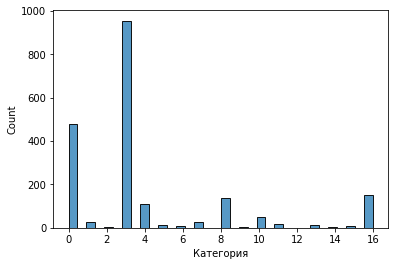

In [92]:
sns.histplot(data=vacancies.Категория)  # Построение гистограммы, проверка сбалансированности исходного набора данных

In [93]:
# Создаем датасет, сливаем текстовые колонки, убираем ненужные колонки
data = vacancies.drop(columns=['id']) # Удаление столбца с ID

# Объединение текстовых колонок в одну
data["text"] = data['Текст Сообщения'].astype(str) + " " + data['Тематика'].astype(str) + " " + data['Ответственное лицо'].astype(str)

# Удаление лишних колонок
data = data.drop(columns=['Текст Сообщения', 'Тематика', 'Ответственное лицо'])
data.head()

,Категория,text
0,3,Помогите начальник Льговского рэс не реагирует...
1,3,<p>По фасаду дома по адресу ул. Урицкого 22 пр...
2,1,Агресивные собаки. На радуге там стая из подро...
3,3,<p>На пересечении &nbsp;улиц Сосновская и Бере...
4,3,<p style=`text-align:justify;`><span style=`ba...


In [94]:
# Подсчет соотношения часла строк к число слов в строке
number_of_samples = len(data)
print("Количество строк (объектов)" , number_of_samples)

number_of_words = 0
for index, row in data.iterrows():
  words = row['text'].split()
  number_of_words += len(words)
number_of_words_per_sample = number_of_words / len(data)
print("Количество cлов в строке" , number_of_words_per_sample)

ratio = number_of_samples / number_of_words_per_sample
print("Соотношение: " , ratio)

# Проводим выбор метода машинного обучения (модели) на основе вычисленного показателя

Количество строк (объектов) 2000
Количество cлов в строке 63.204
Соотношение:  31.64356686285678


*Важно определить соотношение количества строк (объектов) датасета к количеству слов в строке. Если это соотношение мало (< 1500), то использовать группу методов на основе н-грамм (мешок слов), если соотношение велико (>= 1500), то использовать методы, работающие с последовательностью слов.*

# Предварительная обработка текста

In [95]:
from string import punctuation  # Модуль для работы со строками

# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
	return re.sub(r'\s+', ' ', my_string, flags=re.I)

# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))) 

# Создаем колонку в датасете для обработанного текста
data['text_processed'] = list(map(preproccessing, data['text']))
data.head()

,Категория,text,text_processed
0,3,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...
1,3,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,p по фасаду дома по адресу ул урицкого проход...
2,1,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...
3,3,<p>На пересечении &nbsp;улиц Сосновская и Бере...,p на пересечении nbsp улиц сосновская и берег...
4,3,<p style=`text-align:justify;`><span style=`ba...,p style text align justify span style backgro...


In [96]:
# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk

from nltk.stem.snowball import SnowballStemmer    # Стеммер Porter2 - новая версия стеммера Портера
from nltk.corpus import stopwords                 # Библиотека стоп-слов
from nltk import word_tokenize                    # Токенизатор

nltk.download('stopwords')                        # Загрузка стоп-слов
nltk.download('punkt')                            # Загрузка символов пунктуации
stemmer = SnowballStemmer("russian")              # Стеммер для русского языка

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [97]:
russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка
# Расширение списка стоп-слов (см. набор данных)
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan'])

In [98]:
# Провердим стемминг и избавляемся от стоп-слов
stemmed_text_column = []
for text in tqdm(data['text_processed']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_text_column.append(text)

# Создаем новую колонку в наборе данных
data['text_stemmed'] = stemmed_text_column
data['text_stemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помог начальник льговск рэс реагир жалоб мал ветер сид свет имен деревн больш угон улиц стар слобод пожалуйст помог пуска вычист фотоотчет сдела нарушен связа содержан электросет качеств энергоснабжен район частн сектор администрац льговск район'

In [99]:
data.head()

,Категория,text,text_processed,text_stemmed
0,3,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...,помог начальник льговск рэс реагир жалоб мал в...
1,3,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,p по фасаду дома по адресу ул урицкого проход...,p фасад дом адрес ул урицк проход труб газов м...
2,1,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...,агресивн собак радуг ста подросш щенк звросл с...
3,3,<p>На пересечении &nbsp;улиц Сосновская и Бере...,p на пересечении nbsp улиц сосновская и берег...,p пересечен nbsp улиц сосновск берегов nbsp за...
4,3,<p style=`text-align:justify;`><span style=`ba...,p style text align justify span style backgro...,p style text align justify span style backgrou...


## Лемматизация

Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме.

In [100]:
!pip install pymorphy2            # pymorphy2 - морфологический анализатор для русского языка
!pip install pymorphy2-dicts      # пакет со словарями
!pip install DAWG-Python          


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [102]:
morph.parse('шел')[0].normal_form  # Получение нулевой формы слова

'идти'

In [103]:
morph.parse('шел')[0].lexeme  # Все лексемы слова

[Parse(word='идти', tag=OpencorporaTag('INFN,impf,intr'), normal_form='идти', score=1.0, methods_stack=((DictionaryAnalyzer(), 'идти', 1696, 0),)),
 Parse(word='иду', tag=OpencorporaTag('VERB,impf,intr sing,1per,pres,indc'), normal_form='идти', score=1.0, methods_stack=((DictionaryAnalyzer(), 'иду', 1696, 1),)),
 Parse(word='идём', tag=OpencorporaTag('VERB,impf,intr plur,1per,pres,indc'), normal_form='идти', score=1.0, methods_stack=((DictionaryAnalyzer(), 'идём', 1696, 2),)),
 Parse(word='идёшь', tag=OpencorporaTag('VERB,impf,intr sing,2per,pres,indc'), normal_form='идти', score=1.0, methods_stack=((DictionaryAnalyzer(), 'идёшь', 1696, 3),)),
 Parse(word='идёте', tag=OpencorporaTag('VERB,impf,intr plur,2per,pres,indc'), normal_form='идти', score=1.0, methods_stack=((DictionaryAnalyzer(), 'идёте', 1696, 4),)),
 Parse(word='идёт', tag=OpencorporaTag('VERB,impf,intr sing,3per,pres,indc'), normal_form='идти', score=1.0, methods_stack=((DictionaryAnalyzer(), 'идёт', 1696, 5),)),
 Parse(wor

In [104]:
# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(data['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
data['text_lemmed'] = lemm_texts_column

data['text_lemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет именно деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать нарушение связанный содержание электросеть качество энергоснабжение район частное сектор администрация льговский район'

In [105]:
data.head()

,Категория,text,text_processed,text_stemmed,text_lemmed
0,3,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...,помог начальник льговск рэс реагир жалоб мал в...,помочь начальник льговский рэс реагировать жал...
1,3,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,p по фасаду дома по адресу ул урицкого проход...,p фасад дом адрес ул урицк проход труб газов м...,p фасад дом адрес ул урицкий проходить труба г...
2,1,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...,агресивн собак радуг ста подросш щенк звросл с...,агресивный собака радуга стая подрасти щенок з...
3,3,<p>На пересечении &nbsp;улиц Сосновская и Бере...,p на пересечении nbsp улиц сосновская и берег...,p пересечен nbsp улиц сосновск берегов nbsp за...,p пересечение nbsp улица сосновский береговой ...
4,3,<p style=`text-align:justify;`><span style=`ba...,p style text align justify span style backgro...,p style text align justify span style backgrou...,p style text align justify span style backgrou...


## Токенизация

Токенизация - процесс разделения текста на составляющие (слова, предложения, группы слов).

In [106]:
# from nltk import word_tokenize

word_tokenize(data['text_lemmed'][0])

['помочь',
 'начальник',
 'льговский',
 'рэс',
 'реагировать',
 'жалоба',
 'малый',
 'ветер',
 'сидеть',
 'свет',
 'именно',
 'деревня',
 'больший',
 'угон',
 'улица',
 'старый',
 'слобода',
 'пожалуйста',
 'помочь',
 'пускай',
 'вычистить',
 'фотоотчёт',
 'сделать',
 'нарушение',
 'связанный',
 'содержание',
 'электросеть',
 'качество',
 'энергоснабжение',
 'район',
 'частное',
 'сектор',
 'администрация',
 'льговский',
 'район']

## Мешок слов

Мешок слов (bag-of-words) — упрощенное представление текста, которое используется в обработке естественных языков и информационном поиске. В этой модели текст представляется в виде множества его слов без какого-либо учета грамматики и порядка слов, но с сохранением информации об их количестве.


In [107]:
# CountVectorizer - класс конвертации текста в матрицу токенов
from sklearn.feature_extraction.text import CountVectorizer

In [108]:
# Создание матрицы признаков на основе мешка слов
count = CountVectorizer()
bag_of_words = count.fit_transform(data['text_lemmed'])
bag_of_words.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [109]:
count.get_feature_names_out()  # Вывод имен признаков

array(['actual', 'address', 'aesfpebagmfblc', ..., 'ёж', 'ёлка', 'ёлочка'],
      dtype=object)

In [110]:
# Создание матрицы признаков для 2-грамм
count_2gram = CountVectorizer(ngram_range=(2,2))
bag_of_2grams = count_2gram.fit_transform(data['text_lemmed'])
bag_of_2grams.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [111]:
count_2gram.get_feature_names_out()  # Вывод имен признаков

array(['actual amp', 'address span', 'aesfpebagmfblc xn', ...,
       'ёлка новый', 'ёлка озеленить', 'ёлочка надеяться'], dtype=object)

## Взвешивание важности слов - TF-IDF

TF-IDF (TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова (от 0 до 1) пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

Мера TF-IDF часто используется в задачах анализа текстов и информационного поиска, например, как один из критериев релевантности документа поисковому запросу, при расчёте меры близости документов при кластеризации или классификации.

In [112]:
# TfidfVectorizer - класс для преобразования текста в частотные векторы слов
from sklearn.feature_extraction.text import TfidfVectorizer

In [113]:
# Создание матрицы признаков
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(data['text_lemmed'])
feature_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Финальный датасет

In [114]:
# Матрица признаков
X = data['text_lemmed']

# Вектор значений целевых переменных
y = data['Категория']

labels = data['Категория'].unique() # Массив уникальных меток


In [115]:
labels

array([ 3,  1, 16,  0,  6,  8,  4, 13, 10, 11, 14,  7,  5, 15,  2,  9, 12])

In [116]:
# Разбиение на обучающую выборку (70%) и валидационную выборку (30%)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

# Валидация

# Наивный байесовский классификатор (Naive Bayes Classifier)

Наивный байесовский классификатор — простой вероятностный классификатор, основанный на применении теоремы Байеса со строгими (наивными) предположениями о независимости. Достоинством наивного байесовского классификатора является малое количество данных, необходимых для обучения, оценки параметров и классификации.

In [117]:
# Загрузка Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


In [118]:
# Автоматизация предварительных преобразований данных перед обучением модели 
nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()), # Классификатор Naive Bayes для мультиномиальных моделей
              ])

In [119]:
%%time
nb.fit(X_train, y_train)   # Обучение модели

CPU times: user 131 ms, sys: 3.67 ms, total: 135 ms
Wall time: 139 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [120]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_valid)  # Предсказание на валидационных данных

CPU times: user 64.5 ms, sys: 2 ms, total: 66.5 ms
Wall time: 76 ms


In [121]:
# Оценка точности классификации
from sklearn.metrics import accuracy_score
print('accuracy %s' % accuracy_score(y_pred, y_valid))

accuracy 0.7616666666666667


In [122]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       144
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2
           3       0.67      1.00      0.80       284
           4       1.00      0.11      0.19        38
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         9
           8       1.00      0.54      0.70        46
          10       1.00      0.17      0.29        12
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         1
          16       1.00      0.29      0.45        38

    accuracy                           0.76       600
   macro avg       0.38      0.20      0.22       600
weighted avg       0.77   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Логистическая регрессия (Logistic Regression)

Cтатистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой

In [123]:
# Загрузка логистической регрессии
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

In [124]:
%%time
logreg.fit(X_train, y_train) # Обучение модели

CPU times: user 3.31 s, sys: 3.41 s, total: 6.73 s
Wall time: 4.6 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [125]:
%%time
y_pred = logreg.predict(X_valid)   # Предсказание на тестовых данных

CPU times: user 66.4 ms, sys: 26.4 ms, total: 92.7 ms
Wall time: 108 ms


In [126]:
# Оценка точности классификации
print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred))

accuracy 0.9566666666666667
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       144
           1       1.00      0.83      0.91         6
           2       0.00      0.00      0.00         2
           3       0.94      0.99      0.96       284
           4       0.93      0.97      0.95        38
           5       1.00      0.29      0.44         7
           6       1.00      1.00      1.00         1
           7       0.88      0.78      0.82         9
           8       0.98      1.00      0.99        46
          10       1.00      0.92      0.96        12
          11       1.00      0.43      0.60         7
          12       0.00      0.00      0.00         1
          13       1.00      0.75      0.86         4
          15       0.00      0.00      0.00         1
          16       1.00      0.95      0.97        38

    accuracy                           0.96       600
   macro avg       0.78      0.66      0.70       60

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Метод опорных векторов (SVM)



In [127]:
# Загрузка SVM
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=0, max_iter=10, tol=None)),
               ])

In [128]:
%%time
sgd.fit(X_train, y_train)  # Обучение модели

CPU times: user 214 ms, sys: 1.69 ms, total: 216 ms
Wall time: 272 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=10, random_state=0,
                               tol=None))])

In [129]:
%%time
y_pred = sgd.predict(X_valid) # Предсказание на тестовых данных

CPU times: user 55.4 ms, sys: 1.8 ms, total: 57.2 ms
Wall time: 63 ms


In [130]:
labels

array([ 3,  1, 16,  0,  6,  8,  4, 13, 10, 11, 14,  7,  5, 15,  2,  9, 12])

In [131]:
# Оценка точности классификации
print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred))

accuracy 0.9466666666666667
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       144
           1       1.00      1.00      1.00         6
           2       0.00      0.00      0.00         2
           3       0.92      0.99      0.95       284
           4       0.95      0.97      0.96        38
           5       1.00      0.14      0.25         7
           6       1.00      1.00      1.00         1
           7       1.00      0.44      0.62         9
           8       0.98      1.00      0.99        46
           9       0.00      0.00      0.00         0
          10       1.00      0.92      0.96        12
          11       1.00      0.14      0.25         7
          12       0.00      0.00      0.00         1
          13       1.00      0.50      0.67         4
          15       0.00      0.00      0.00         1
          16       1.00      0.92      0.96        38

    accuracy                           0.95       60

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

#CaTBOOST

In [162]:
modelCat = CatBoostClassifier()

In [163]:
cbc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                ('tfidf', TfidfTransformer()),
                ('clf', CatBoostClassifier(verbose=False)),
               ])

In [164]:
cbc.fit(X_train, y_train)

Learning rate set to 0.080496
0:	learn: 2.2579188	total: 2.14s	remaining: 35m 35s
1:	learn: 1.9496182	total: 3.79s	remaining: 31m 30s
2:	learn: 1.7437921	total: 5.56s	remaining: 30m 47s
3:	learn: 1.5698972	total: 7.4s	remaining: 30m 41s
4:	learn: 1.4599006	total: 8.41s	remaining: 27m 54s
5:	learn: 1.3652232	total: 9.48s	remaining: 26m 10s
6:	learn: 1.2821657	total: 10.6s	remaining: 24m 56s
7:	learn: 1.2196796	total: 11.8s	remaining: 24m 21s
8:	learn: 1.1474915	total: 13.4s	remaining: 24m 34s
9:	learn: 1.0810288	total: 14.9s	remaining: 24m 39s
10:	learn: 1.0359464	total: 16.6s	remaining: 24m 51s
11:	learn: 0.9943217	total: 18.3s	remaining: 25m 8s
12:	learn: 0.9478371	total: 19s	remaining: 24m 5s
13:	learn: 0.9132866	total: 19.8s	remaining: 23m 11s
14:	learn: 0.8827968	total: 20.5s	remaining: 22m 24s
15:	learn: 0.8458188	total: 21.2s	remaining: 21m 43s
16:	learn: 0.8174956	total: 21.9s	remaining: 21m 6s
17:	learn: 0.7898114	total: 22.6s	remaining: 20m 31s
18:	learn: 0.7649889	total: 23.3

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7f6eefc4bb10>)])

In [165]:
y_pred = cbc.predict(X_valid)

In [166]:
print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred))

accuracy 0.9533333333333334
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       144
           1       1.00      1.00      1.00         6
           2       0.00      0.00      0.00         2
           3       0.93      0.99      0.96       284
           4       1.00      0.95      0.97        38
           5       1.00      0.14      0.25         7
           6       1.00      1.00      1.00         1
           7       1.00      0.44      0.62         9
           8       1.00      0.98      0.99        46
           9       0.00      0.00      0.00         0
          10       1.00      0.92      0.96        12
          11       0.71      0.71      0.71         7
          12       0.00      0.00      0.00         1
          13       1.00      0.50      0.67         4
          15       0.00      0.00      0.00         1
          16       0.95      0.95      0.95        38

    accuracy                           0.95       60

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# Лучший результат на валидации

In [168]:
q = {'model' : ['NBC', 'SVM', 'LR', 'CBC'], 
     'Результат' : [0.77 , 0.95 , 0.97, 0.95]}

In [169]:
itog  =  pd.DataFrame(data = q)

In [170]:
itog.sort_values('Результат', ascending=False)

,model,Результат
2,LR,0.97
1,SVM,0.95
3,CBC,0.95
0,NBC,0.77


*Вывод: лучший результат на валидации на Логистической регрессии*

#ТЕСТ

*Подготовим тест*

In [135]:
test_data = pd.read_csv('/content/drive/MyDrive/Хакатоны/Курск слова/test_dataset_test.csv')

In [136]:
test_data

,id,Текст Сообщения,Тематика,Ответственное лицо
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,Неработающее наружное освещение,Администрация Курчатовского района
1,1422,<p>Уже вторую неделю не горит уличное освещени...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...
2,2782,Не работает освещение во дворе дома 11а по Эне...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...
3,2704,После покоса сорной растительности на газоне м...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска
4,1,<p>Прошу принять меры к водителю маршрута 263:...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска
...,...,...,...,...
995,2619,"Добрый день! Я и моя семья жители пос Волокно,...",Неприятные запахи,Комитет природных ресурсов Курской области
996,2518,На Лазарева 5 г.Щигры ветка тополя скоро выбье...,Аварийные деревья,Администрация города Щигры
997,2524,Перед входом Комитет образования Курска ямы...,Нарушение дорожного покрытия (ямы) на дорогах...,Комитет дорожного хозяйства города Курска
998,1577,<p>Доброго времени суток</p><p>У меня на пол г...,Сертификат переболевшего,Комитет здравоохранения Курской области


In [137]:
test = test_data

In [138]:
# Создаем датасет, сливаем текстовые колонки, убираем ненужные колонки
test = test.drop(columns=['id']) # Удаление столбца с ID

# Объединение текстовых колонок в одну
test["text"] = test['Текст Сообщения'].astype(str) + " " + test['Тематика'].astype(str) + " " + test['Ответственное лицо'].astype(str)

# Удаление лишних колонок
test = test.drop(columns=['Текст Сообщения', 'Тематика', 'Ответственное лицо'])
test.head()

,text
0,<p>Здравствуйте. На улице Мира &nbsp;было заме...
1,<p>Уже вторую неделю не горит уличное освещени...
2,Не работает освещение во дворе дома 11а по Эне...
3,После покоса сорной растительности на газоне м...
4,<p>Прошу принять меры к водителю маршрута 263:...


In [139]:
test['text_processed'] = list(map(preproccessing, test['text']))
test.head()

,text,text_processed
0,<p>Здравствуйте. На улице Мира &nbsp;было заме...,p здравствуйте на улице мира nbsp было замене...
1,<p>Уже вторую неделю не горит уличное освещени...,p уже вторую неделю не горит уличное освещени...
2,Не работает освещение во дворе дома 11а по Эне...,не работает освещение во дворе дома а по энерг...
3,После покоса сорной растительности на газоне м...,после покоса сорной растительности на газоне м...
4,<p>Прошу принять меры к водителю маршрута 263:...,p прошу принять меры к водителю маршрута пос ...


In [140]:
# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(test['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
test['text_lemmed'] = lemm_texts_column

test['text_lemmed'][0]

  0%|          | 0/1000 [00:00<?, ?it/s]

'p здравствуйте улица мир nbsp заменить наружное освещение именно заменить лампа nbsp энергосберегающий лампа протяжение несколько месяц освещение улица отсутствовать последний улица осветить это зима приблизительно каждый день человек работать часовой смена многие возвращаться очень поздно дать проблема улица посёлок nbsp p неработающий наружное освещение администрация курчатовский район'

In [141]:
test['text_lemmed']

0      p здравствуйте улица мир nbsp заменить наружно...
1      p второй неделя гореть уличный освещение p p n...
2      работать освещение двор дом энергетик световой...
3      покос сорный растительность газон тротуар прое...
4      p просить принять мера водитель маршрут пос се...
                             ...                        
995    добрый день семья житель пос волокно просыпать...
996    лазарев г щигры ветка тополь скоро выбить стек...
997    вход комитет образование курск ям дорога наруш...
998    p добрый время сутки p p пол год медотвод вакц...
999    добрый день многодетный мама младший ребёнок г...
Name: text_lemmed, Length: 1000, dtype: object

*Логистчиеская регрессия на тесте*

In [173]:
pred = logreg.predict(test['text_lemmed'])
df = pd.DataFrame(pred)
u = (test_data['id'].to_frame()).join(df)
u = u.rename(columns={0 : 'Категория'})
u.to_csv('./lr.csv', index=False)

**Catboost**

In [174]:
pred = cbc.predict(test['text_lemmed'])
df = pd.DataFrame(pred)
u = (test_data['id'].to_frame()).join(df)
u = u.rename(columns={0 : 'Категория'})
u.to_csv('./cbc.csv', index=False)

--------------------------